In [1]:
%matplotlib inline
from glob import glob
from soma import aims
import pandas as pd
import numpy as np
from scipy import stats 
import os.path as osp
from nilearn import plotting
from IPython.display import display_html, display_jpeg, display

/home/grg/jupyter/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading the data

In [2]:
datadir = '/home/grg/upf'
controls = sorted(glob(osp.join(datadir, 'Data/Control/s12*.nii')))
diazepam = sorted(glob(osp.join(datadir, 'Data/Diazepam/s12*.nii')))
rois = glob(osp.join(datadir, 'Data/ROI/*.nii'))
roinames = [each.split('/')[-1][:-4] for each in rois]

In [30]:
data = pd.read_excel(osp.join(datadir, 'Dades.xlsx'), header=1)

table_cont = []    
table_diaz = []    

# For controls first
for i, cont in enumerate(controls):
    line = []
    c = aims.read(cont).arraydata()  # Loads the subject's image

    for j, roiname in enumerate(roinames): 
        roi = aims.read(rois[j]).arraydata()  # Loads the ROI mask
        line.append(c[roi==1].mean())  # Gets the mean value over the ROI
        
    table_cont.append(line)

# For diazepam subjects then
for i, diaz in enumerate(diazepam):
    line = []
    d = aims.read(diaz).arraydata()
    for j, roiname in enumerate(roinames):
        roi = aims.read(rois[j]).arraydata()
        line.append(d[roi==1].mean())
        
    table_diaz.append(line)

In [29]:
pd.DataFrame(table_cont, columns=roinames).head()

,LFC,right_thalamus,ROC,CB,LPC,LTC,left_thalamus,CG,RFC,LOC,RTC,RPC
0,179.358994,186.699799,219.575668,180.775497,194.883606,177.751236,185.650955,211.669113,207.848938,211.366180,189.847733,208.110031
1,171.325226,148.514114,221.105530,176.712311,173.886871,168.469009,160.214767,188.369034,194.161224,213.974136,184.699905,175.787064
2,196.760956,187.048477,221.141190,172.515274,216.794312,193.338623,193.496536,221.980804,211.531433,230.271393,192.251266,211.688156
3,199.775345,188.935928,238.674820,174.658737,209.249725,189.484604,185.881027,228.031403,231.884216,235.167023,205.941284,223.173935
4,207.801010,183.258347,247.195282,181.636459,230.883118,205.805573,179.413315,236.425095,235.574280,243.522293,223.400970,238.598862


In [26]:
table = table_cont[:]
table.extend(table_diaz)
print len(table_cont), len(table_diaz)
roivalues = pd.DataFrame(table, columns=roinames)
groups = ['controls'] * 31
groups.extend(['patients'] * 31)
roivalues['group'] = groups
roivalues.groupby('group').head()

31 31


,LFC,right_thalamus,ROC,CB,LPC,LTC,left_thalamus,CG,RFC,LOC,RTC,RPC,group
0,179.358994,186.699799,219.575668,180.775497,194.883606,177.751236,185.650955,211.669113,207.848938,211.366180,189.847733,208.110031,controls
1,171.325226,148.514114,221.105530,176.712311,173.886871,168.469009,160.214767,188.369034,194.161224,213.974136,184.699905,175.787064,controls
2,196.760956,187.048477,221.141190,172.515274,216.794312,193.338623,193.496536,221.980804,211.531433,230.271393,192.251266,211.688156,controls
3,199.775345,188.935928,238.674820,174.658737,209.249725,189.484604,185.881027,228.031403,231.884216,235.167023,205.941284,223.173935,controls
4,207.801010,183.258347,247.195282,181.636459,230.883118,205.805573,179.413315,236.425095,235.574280,243.522293,223.400970,238.598862,controls
31,163.051575,158.068573,191.719406,173.171509,163.455994,160.453979,160.256378,185.482498,186.323242,186.157883,175.077118,172.901855,patients
32,183.672501,178.068909,213.720749,170.943436,198.986069,181.608826,181.978516,205.605286,207.568832,209.636078,187.987305,198.357254,patients
33,147.552734,164.469803,188.526093,159.121475,161.353836,148.640457,160.614075,184.469742,172.435150,179.419586,160.928955,168.320023,patients
34,167.137741,181.582306,209.816757,157.065018,183.041168,163.135193,187.674652,194.217102,187.559280,200.215546,171.823303,180.024445,patients
35,158.228973,172.708038,200.012039,168.890778,173.728775,166.016052,172.897018,191.115204,181.449203,192.831467,171.918381,180.107162,patients


Converting values to SUV...

In [8]:
def convert(val, p, d):
    cf = 65.98
    voxel_size = .008
    nci_to_bq = 37.0
    val = val * cf / nci_to_bq / voxel_size
    val = val / (d / p)
    return val

In [39]:
ttests = []

suv_controls = []
suv_diaz = []
suv_controls_wb = []
suv_controls_wm = []

# Converting kg to g and mCi to nCi
weights_cont = data['Pes [Kg]'] * 1000.0
dose_cont = data['Dosi [mCi]'] * 1000000.0
weights_diaz = data['Pes [Kg].1'] * 1000.0
dose_diaz = data['Dosi [mCi].1'] * 1000000.0

for i, h in enumerate(roinames):
    # Converting values to SUV for controls
    a = np.array(np.array(table_cont)[:,i], dtype=np.float64)
    a = convert(a, weights_cont, dose_cont)
    suv_controls.append(a)
    
    # Converting values to SUV for diazepam
    b = np.array(np.array(table_diaz)[:,i], dtype=np.float64)
    b = convert(b, weights_diaz, dose_diaz)  
    suv_diaz.append(b)

    # Computing t-tests
    ttests.append(stats.ttest_ind(a, b)[1] / 2.0)    

In [40]:
suv_controls = np.array(suv_controls).transpose()
suv_diaz = np.array(suv_diaz).transpose()

Now what effects do we observe ?

In [43]:
pd.DataFrame(ttests, index=roinames, columns=['suv'])


,suv
LFC,0.396962
right_thalamus,0.210560
ROC,0.296078
CB,0.066951
LPC,0.443431
LTC,0.183824
left_thalamus,0.192545
CG,0.285838
RFC,0.432132
LOC,0.324266


# Plots

In [44]:
def plot_data(suv_controls, suv_diaz, ylim=None):
    from matplotlib import pyplot as plt
    import matplotlib
    matplotlib.rc('figure', facecolor='white')

    fig, ax1 = plt.subplots(figsize=(10, 6))
    pos_cont = xrange(0,len(roinames)*2,2)
    pos_diaz = xrange(1,len(roinames)*2,2)

    box_c = plt.boxplot(np.array(suv_controls), positions=pos_cont, patch_artist=True)
    for patch in box_c['boxes']:
        patch.set(facecolor='cyan')

    box_d = plt.boxplot(np.array(suv_diaz), positions=pos_diaz, patch_artist=True)
    for patch in box_d['boxes']:
        patch.set(facecolor='pink')
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgray',
                   alpha=0.5)
    ax1.set_xlim(-1)
    if not ylim is None:
        ax1.set_ylim([0,ylim])
    plt.xticks(rotation=70)
    ax1.set_xticks(list(np.array(range(0, 2*len(roinames), 2)) + np.array([0.5]*len(roinames))))
    ax1.set_xticklabels(roinames)

    plt.figtext(0.80, 0.0015, 'controls', backgroundcolor='cyan', color='black', weight='roman', size='x-small')
    plt.figtext(0.80, 0.025, 'diazepam', backgroundcolor='pink', color='black', weight='roman', size='x-small')
    plt.show()

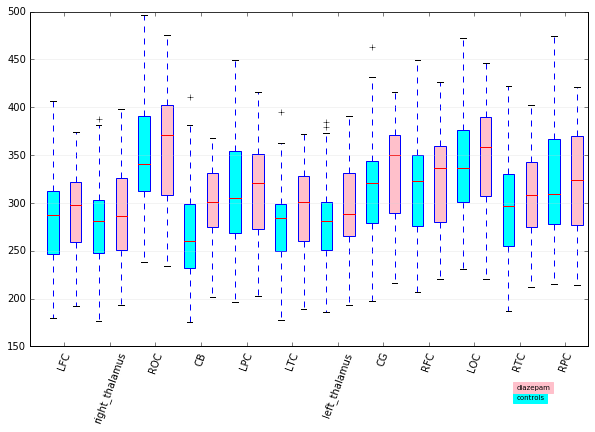

In [45]:
plot_data(suv_controls, suv_diaz)

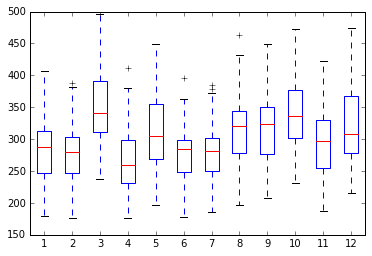

In [49]:
from matplotlib import pyplot as plt
_ = plt.boxplot(np.array(suv_controls))